In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d, gaussian_kde
from numba import njit
from astropy.io import fits, ascii
import astropy.coordinates as coord
import astropy.units as u
from scipy.ndimage import gaussian_filter

from astropy.coordinates import SkyCoord, Galactic, Galactocentric
from astropy import units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0, where=a>0), where=a>0)

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    if isinstance(ans, float):
        if a <= 0:
            ans = np.nan
    else:
        ans[a <= 0] = np.nan
    
    return ans

In [4]:
print(get_time(1) - 10.6)
print(get_time(2.0542, redshift=True))
print(get_time(1.5, redshift=True))

3.20271998548524
3.2027852424229564
4.28185389971363


In [5]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [6]:
def get_SFH(snapnum, subID, tbins, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals', 'GFM_InitialMass']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    minit = snap['GFM_InitialMass']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - sub['SubhaloPos']
    r = np.linalg.norm(pos, axis=1)
    rhalf = sub['SubhaloHalfmassRadType'][4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    GFM_SOLAR_ABUNDANCE_OXYGEN    = 0.0057
    GFM_SOLAR_ABUNDANCE_NEON      = 0.0012
    GFM_SOLAR_ABUNDANCE_SILICON   = 0.0007
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    # MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    # MgH = snap['GFM_Metals'][:,4] / GFM_SOLAR_ABUNDANCE_OXYGEN
    # MgH = snap['GFM_Metals'][:,5] / GFM_SOLAR_ABUNDANCE_NEON
    # MgH = snap['GFM_Metals'][:,5] / GFM_SOLAR_ABUNDANCE_NEON
    MgH = snap['GFM_Metals'][:,7] / GFM_SOLAR_ABUNDANCE_SILICON
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.05
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, minit, keys, is_star_in_SN


In [7]:
# Now get APOKASC2 ages
fname = '../../data/APOKASC3/Table4.data'
data = ascii.read(fname)
    
# logage = data['LogAge']
# logage_err_u = data['E_LogAge']
# logage_err_l = data['e_LogAge']

# age = 10.**logage
# age_err_u = 10.**(logage_err_u + logage) - age
# age_err_l = 10.**(logage_err_l + logage) - age

# age /= 1000
# age_err_u /= 1000
# age_err_l /= 1000

# age_err = np.maximum(age_err_u, -age_err_l)

In [8]:
data

KIC,Evol_State,ES_Source,Cat_Tab,Seis_Source,Spec_Source,N_Numax_Fil,N_DNu_Fil,Nquar,Numax,S_Numax,DNu,S_DNu,F_DNu,S_FDNu,F_Numax,Mass,S_Mass,Radius,S_Radius,Logg_Seis,S_Logg_Seis,Teff,S_Teff,Logg_Spec,S_Logg_Spec,[Fe/H],S_[Fe/H],[Alp/Fe],S_[Alp/Fe],[C/Fe],S_[C/Fe],[N/Fe],S_[N/Fe],InvR_Gaia,S_InvR_Gaia,Age_Cat,Age_RGB,S_Age_RGB+,S_Age_RGB-,Age_RC_AGB,S_Age_RC+,S_Age,Vsini,Alpha_Cat,GAIAEDR3_SOURCE_ID,2MASS_ID
int64,str7,str4,str8,str4,str4,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,str5,int64,str18
893214,RGB,Seis,Gold,WAvg,DR17,8,5,15,40.5841,0.2874,4.3254,0.0289,1.0277,0.005,0.9976,1.4404,0.0602,11.0014,0.2055,2.5146,0.0042,4718.9233,44.7811,2.4559,0.058,-0.2617,0.058,0.0815,0.022,-0.0626,0.0135,0.2483,0.0164,0.082389,0.002866,RGB,2.8815,0.298,-0.2639,2.8815,0.298,-0.2639,0.0,Apoor,2050237616959273728,2M19245967+3638183
1026180,RC,Spec,Gold,WAvg,DR17,8,5,4,35.6089,0.2338,3.9208,0.0265,0.9972,0.005,0.9936,1.5334,0.0633,12.2361,0.2278,2.4512,0.0039,4576.1016,40.5161,2.4066,0.058,0.2741,0.058,0.0215,0.022,0.0568,0.0084,0.3647,0.0107,0.085599,0.002161,RC,-9999.0,-9999.0,-9999.0,3.1325,0.2754,-0.1905,0.0,Apoor,2050237174589477888,2M19241923+3645378
1026309,RGB,Seis,Silver,WAvg,DR17,8,4,18,16.6974,0.5675,1.9432,0.0805,1.0072,0.005,1.0205,2.642,0.518,23.2678,2.0993,2.1176,0.0148,4479.2246,39.7068,2.2388,0.058,0.1609,0.058,-0.0295,0.022,-0.0823,0.0088,0.2913,0.011,0.047943,0.001239,RGB_AGB,0.5842,0.1481,-0.109,0.7082,0.1832,-0.1405,0.0,Apoor,2050236934071312384,2M19242636+3643594
1026452,RC,Seis,Gold,WAvg,DR17,8,5,18,34.3652,0.2256,3.9749,0.0268,0.9953,0.005,0.9936,1.4618,0.0599,11.9485,0.2215,2.451,0.0044,4910.6035,53.0693,2.4907,0.058,-0.2652,0.058,0.0658,0.022,0.0005,0.0189,0.1605,0.0222,0.075937,0.003795,RC,-9999.0,-9999.0,-9999.0,2.6495,0.2319,-0.1919,0.0,Apoor,2050243050104808960,2M19243452+3647244
1027110,RGB,Seis,Silver,WAvg,DR17,8,4,18,6.5198,0.1616,1.1613,0.044,1.0511,0.005,1.0535,1.0367,0.1769,23.337,1.8791,1.6949,0.011,4194.4375,37.9582,1.7495,0.058,-0.3017,0.058,0.2615,0.022,0.1451,0.0109,0.1366,0.0131,0.040245,0.001509,RGB_AGB,9.0694,8.0551,-3.8133,7.2088,4.6171,-2.3475,0.0,Arich,2050239201814200192,2M19250937+3644599
1027337,RGB,Seis,Gold,WAvg,DR17,9,6,18,74.3689,0.4491,6.9661,0.0418,1.0282,0.005,0.9959,1.2676,0.0489,7.6702,0.133,2.7732,0.0038,4621.996,41.3674,2.7836,0.058,0.2081,0.058,0.0354,0.022,0.062,0.009,0.2898,0.0115,0.123008,0.0033,RGB,5.8519,0.5953,-0.5247,5.8519,0.5953,-0.5247,0.0,Apoor,2050240782362231552,2M19252021+3647118
1027707,RGB,Seis,Silver,WAvg,DR17,6,3,18,3.0206,0.0885,0.5593,0.0309,1.0265,0.005,1.0663,2.0033,0.4792,48.0566,5.5208,1.3484,0.0129,3961.365,35.9864,1.4062,0.058,0.1105,0.058,0.0356,0.022,0.0455,0.0079,0.1751,0.0094,0.018104,0.001509,RGB_AGB,1.3052,0.6198,-0.3779,1.5494,0.4593,-0.4138,0.0,Apoor,2050240129527252096,2M19253846+3646103
1160655,RGB,Seis,Silver,WAvg,DR17,5,2,18,1.5726,0.0502,0.3698,0.024,1.0608,0.005,1.0525,1.1903,0.3305,52.0838,6.9807,1.058,0.0139,3837.788,33.9314,0.9088,0.058,-0.1446,0.058,0.1098,0.022,0.0582,0.0089,0.2023,0.0105,0.018767,0.001236,RGB_AGB,5.7073,8.7454,-2.777,5.013,5.3362,-2.0267,0.0,Arich,2050252395953454464,2M19232193+3650379
1160684,RC,Spec,Gold,WAvg,DR17,9,6,17,26.8674,0.1516,3.5003,0.0212,0.9981,0.005,0.9936,1.1208,0.0426,11.8817,0.2048,2.3406,0.0043,4830.3506,56.4954,2.382,0.058,-0.3194,0.058,0.0803,0.022,0.0102,0.0231,0.1651,0.0262,0.086569,0.008578,RC,-9999.0,-9999.0,-9999.0,5.307,0.4989,-0.4825,0.0,Apoor,2050254113940398976,2M19232466+3652089


In [9]:
np.unique(data['Age_Cat'])

AGB
NONE
RC
RC/RGB
RGB
RGB_AGB


In [10]:
np.sum(data['Age_Cat']=='RC/RGB')

11

In [11]:
def get_age_age_err(data):
    age_RC      = data['Age_RC_AGB'][data['Age_Cat'] == 'RC']
    age_RCp     = data['S_Age_RC+'][data['Age_Cat'] == 'RC']
    age_RCm     = data['S_Age'][data['Age_Cat'] == 'RC']
    age_RC_err  = np.maximum(age_RCp, -age_RCm)

    age_AGB     = data['Age_RC_AGB'][data['Age_Cat'] == 'AGB']
    age_AGBp    = data['S_Age_RC+'][data['Age_Cat'] == 'AGB']
    age_AGBm    = data['S_Age'][data['Age_Cat'] == 'AGB']
    age_AGB_err = np.maximum(age_AGBp, -age_AGBm)

    age_RGB     = data['Age_RGB'][data['Age_Cat'] == 'RGB']
    age_RGBp    = data['S_Age_RGB+'][data['Age_Cat'] == 'RGB']
    age_RGBm    = data['S_Age_RGB-'][data['Age_Cat'] == 'RGB']
    age_RGB_err = np.maximum(age_RGBp, -age_RGBm)

    age = np.full_like(data['Age_RGB'], np.nan)
    age[data['Age_Cat'] == 'RC']  = age_RC
    age[data['Age_Cat'] == 'AGB'] = age_AGB
    age[data['Age_Cat'] == 'RGB'] = age_RGB

    age_err = np.full_like(data['Age_RGB'], np.nan)
    age_err[data['Age_Cat'] == 'RC']  = age_RC_err
    age_err[data['Age_Cat'] == 'AGB'] = age_AGB_err
    age_err[data['Age_Cat'] == 'RGB'] = age_RGB_err
    
    return age, age_err

In [12]:
def get_MW_plot_data(N_FeH=128, N_MgFe=128, logFeH_lim=(-1.5, 0.5), logMgFe_lim=(-0.2, 0.8),
                     logFeH0_list = [-0.5, -0.25, 0, 0.25]):
# N_FeH = 128
# N_MgFe = 128
# logFeH_lim = (-1.5, 0.5)
# logMgFe_lim = (-0.2, 0.8)
# if True:
    hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')
    
    # first do quality cuts
    no_starflag = hdul[1].data.STARFLAG == 0
    good_snr = hdul[1].data.SNR > 200
    good_vscatter = hdul[1].data.VSCATTER < 1
    good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1
    good_logg = np.logical_and(hdul[1].data.LOGG < 3.5, hdul[1].data.LOGG_ERR < 0.2)
    good_nan_FeH = np.logical_not(np.isnan(hdul[1].data.FE_H))
    good_nan_MgFe = np.logical_not(np.isnan(hdul[1].data.MG_FE))
    
    aspcap_keys = np.logical_and(no_starflag, good_snr)
    aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
    aspcap_keys = np.logical_and(aspcap_keys, good_parallax)
    aspcap_keys = np.logical_and(aspcap_keys, good_logg)
    aspcap_keys = np.logical_and(aspcap_keys, good_nan_FeH)
    aspcap_keys = np.logical_and(aspcap_keys, good_nan_MgFe)
    
    # Define your data
    ra = hdul[1].data.RA * u.deg
    dec = hdul[1].data.DEC * u.deg
    parallax = hdul[1].data.GAIAEDR3_PARALLAX * u.mas

    pmra = hdul[1].data.GAIAEDR3_PMRA * u.mas/u.yr
    pmdec = hdul[1].data.GAIAEDR3_PMDEC * u.mas/u.yr
    rv = hdul[1].data.VHELIO_AVG * u.km/u.s

    # Convert parallax to distance
    distance = parallax.to(u.pc, equivalencies=u.parallax())

    # Create a SkyCoord object
    coords = SkyCoord(ra=ra, dec=dec, distance=distance, 
                      pm_ra_cosdec=pmra, pm_dec=pmdec, 
                      radial_velocity=rv, frame='icrs')

    # Convert to Galactocentric coordinates
    gal_coord = coords.transform_to(Galactocentric())

    # Now you can access the galactocentric coordinates
    x, y, z = gal_coord.x, gal_coord.y, gal_coord.z
    vx, vy, vz = gal_coord.v_x, gal_coord.v_y, gal_coord.v_z

    # compute angular momenta
    Lz = x * vy - y * vx
    Lzsun = -Galactocentric().galcen_distance * Galactocentric().galcen_v_sun.d_y
    
    # Apply keys
    SN_key = np.abs((Lz-Lzsun)/Lzsun) < 0.2
    SN_key = np.logical_and(SN_key, np.abs(z) < 3*u.kpc)
    SN_key = np.logical_and(SN_key, aspcap_keys)
    
    # Get chemistry
    logFeH = hdul[1].data.FE_H[SN_key]
    logMgFe = hdul[1].data.MG_FE[SN_key]
    logNFe = hdul[1].data.N_FE[SN_key]
    logCFe = hdul[1].data.N_FE[SN_key]
    logNCFe = logNFe + logCFe - logFeH
    
    logFeH_err = hdul[1].data.FE_H_ERR[SN_key]
    logMgFe_err = hdul[1].data.MG_FE_ERR[SN_key]
    
    # Create bins
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    # Calculate the midpoints of each bin
    FeH_centers = (FeH_bins[:-1] + FeH_bins[1:]) / 2
    MgFe_centers = (MgFe_bins[:-1] + MgFe_bins[1:]) / 2

    # Create a meshgrid of all combinations of MgFe and FeH centers
    FeH_grid, MgFe_grid = np.meshgrid(FeH_centers, MgFe_centers, indexing='ij')

    # Stack the grids to create an array of shape (200, 2)
    bin_centers = np.vstack([FeH_grid.ravel(), MgFe_grid.ravel()])
    
    # Create gaussian kde of fid data
    data0 = np.vstack([logFeH, logMgFe])
    kde0 = gaussian_kde(data0)
    H0 = np.reshape(kde0(bin_centers), (N_FeH, N_MgFe))
    H0 /= dFeH*dMgFe*np.sum(H0)
    
    # Get keys
    dlogFeH0 = 0.2
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        keys.append(in_FeH)
    
    # Now get APOKASC2 ages
    # fname = '../../data/APOKASC2/table5.dat'
    # readme = '../../data/APOKASC2/ReadMe'
    # data = ascii.read(fname, readme=readme)
    fname = '../../data/APOKASC3/Table4.data'
    data = ascii.read(fname)
    
    age, age_err = get_age_age_err(data)
    
    # logage = data['LogAge']
    # logage_err_u = data['E_LogAge']
    # logage_err_l = data['e_LogAge']

    # age = 10.**logage
    # age_err_u = 10.**(logage_err_u + logage) - age
    # age_err_l = 10.**(logage_err_l + logage) - age

    # age /= 1000
    # age_err_u /= 1000
    # age_err_l /= 1000

    # age_err = np.maximum(age_err_u, -age_err_l)
    
    # cross match with full APOGEE catalog
    out = {}
    
    out['ages'] = np.full_like(logFeH, np.nan)
    out['age_err'] = np.full_like(logFeH, np.nan)
    IDs = [d for d in data['2MASS_ID']]
    apogeeIDs = hdul[1].data.APOGEE_ID[SN_key]
    apogee_id_map = {ID: idx for idx, ID in enumerate(apogeeIDs)}
    
    for i,ID in enumerate(tqdm(IDs)):
        if ID in apogeeIDs:
            out['ages'][apogee_id_map[ID]] = age[i]
            out['age_err'][apogee_id_map[ID]] = age_err[i]
            
    # keys = np.array([apogee_id_map[ID] for ID in IDs])
    # out['ages'][keys] = age
    
    # print out sample size
    print('num ASPCAP: ', len(logFeH))
    print('num APOKASC2: ', np.sum(np.logical_not(np.isnan(out['ages']))))
    
    out['logFeH']       = logFeH
    out['logMgFe']      = logMgFe
    out['logNCFe']      = logNCFe
    out['logFeH_err']   = logFeH_err
    out['logMgFe_err']  = logMgFe_err
    out['N_FeH']        = N_FeH
    out['N_MgFe']       = N_MgFe
    out['logFeH_lim']   = logFeH_lim
    out['logMgFe_lim']  = logMgFe_lim
    out['FeH_centers']  = FeH_centers
    out['MgFe_centers'] = MgFe_centers
    out['H']            = H0
    out['logFeH0_list'] = logFeH0_list
    out['keys']         = keys
    out['is_obs']       = True
    
    return out
    

In [13]:
def get_sim_plot_data(subID, snapnum, slope=0, snapnum_slope=40, N_FeH=128, N_MgFe=128,
                 logFeH_lim=(-1.5, 0.5), logMgFe_lim=(0, 1.0),
                 logFeH0_list=[-0.75, -0.5, -0.25, 0]):
    # Load in data
    t_snapnum = meta['time'][snapnum]
    tbins = np.linspace(0, t_snapnum, 100)
    tlim = [tbins[0], tbins[-1]]
    tcenter, sfh, tform, logFeH, logMgFe, minit, keys, is_star_in_SN = \
        get_SFH(snapnum, subID, tbins, logFeH0_list)
    
    # Add slope to MgFe
    slope *= -1
    t0 = meta['time'][snapnum_slope]
    correct = slope * (tform - t0)
    correct[tform > t0] = 0
    logMgFe_slope = logMgFe + correct
    
    # Create bins
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    # Calculate the midpoints of each bin
    FeH_centers = (FeH_bins[:-1] + FeH_bins[1:]) / 2
    MgFe_centers = (MgFe_bins[:-1] + MgFe_bins[1:]) / 2

    # Create a meshgrid of all combinations of MgFe and FeH centers
    FeH_grid, MgFe_grid = np.meshgrid(FeH_centers, MgFe_centers, indexing='ij')

    # Stack the grids to create an array of shape (200, 2)
    bin_centers = np.vstack([FeH_grid.ravel(), MgFe_grid.ravel()])
    
    # Create gaussian kde of fid data
    data0 = np.vstack([logFeH[is_star_in_SN], logMgFe[is_star_in_SN]])
    kde0 = gaussian_kde(data0)
    H0 = np.reshape(kde0(bin_centers), (N_FeH, N_MgFe))
    # H0 /= dFeH*dMgFe
    H0 /= (dFeH*dMgFe*np.sum(H0))
    
    # Create gaussian kde of sloped data
    data1 = np.vstack([logFeH[is_star_in_SN], logMgFe_slope[is_star_in_SN]])
    kde1 = gaussian_kde(data1)
    H1 = np.reshape(kde1(bin_centers), (N_FeH, N_MgFe))
    # H1 /= dFeH*dMgFe
    H1 /= (dFeH*dMgFe*np.sum(H1))
    
    # store in output
    out = {}
    out_slope = {}
    
    for o in [out, out_slope]:
        o['N_FeH']         = N_FeH
        o['N_MgFe']        = N_MgFe
        o['logFeH_lim']    = logFeH_lim
        o['logMgFe_lim']   = logMgFe_lim
        o['logFeH0_list']  = logFeH0_list
    
        o['tcenter']       = tcenter
        o['sfh']           = sfh
        o['tform']         = tform
        o['logFeH']        = logFeH
        o['keys']          = keys
        o['is_star_in_SN'] = is_star_in_SN
        o['tbins']         = tbins
    
        o['FeH_bins']      = FeH_bins
        o['MgFe_bins']     = MgFe_bins
        o['FeH_centers']   = FeH_centers
        o['MgFe_centers']  = MgFe_centers
        o['is_obs']        = False
    
    out['H'] = H0
    out['logMgFe']         = logMgFe
    out['minit']           = minit
    
    out_slope['slope']         = slope
    out_slope['logMgFe'] = logMgFe_slope
    out_slope['H'] = H1
       
    return out, out_slope

In [14]:
%%time
N_FeH = 64
N_MgFe = 64
MWdat = get_MW_plot_data(N_FeH=N_FeH, N_MgFe=N_MgFe)

100%|██████████| 15808/15808 [00:12<00:00, 1252.54it/s]


num ASPCAP:  54777
num APOKASC2:  2827
CPU times: user 18.2 s, sys: 4.73 s, total: 22.9 s
Wall time: 25.2 s


In [15]:
%%time
N_FeH   = 64
N_MgFe  = 64
# subID   = 172175
# snapnum = 40
subID   = 392276
snapnum = 99
slope   = 0.1
simdat, simdat_slope = get_sim_plot_data(subID, snapnum, slope=slope, N_FeH=N_FeH, N_MgFe=N_MgFe)

CPU times: user 50.3 s, sys: 134 ms, total: 50.4 s
Wall time: 51.3 s


In [16]:
def plot_panel(fig, ax0, ax1, dat, vmin=None, vmax=None, levels=[0.1, 1.5, 10]):
    
    logFeH_lim    = dat['logFeH_lim']
    logMgFe_lim   = dat['logMgFe_lim']
    logFeH0_list  = dat['logFeH0_list']
    N_FeH         = dat['N_FeH']
    N_MgFe        = dat['N_MgFe']
    FeH_centers   = dat['FeH_centers']
    MgFe_centers  = dat['MgFe_centers']
    logFeH        = dat['logFeH']
    logMgFe       = dat['logMgFe']
    keys          = dat['keys']
    H             = dat['H']
    
    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    im = ax0.imshow(H.T, origin='lower', extent=extent,
                    cmap='Greys', norm=norm, interpolation='None')
    cont = ax0.contour(FeH_centers, MgFe_centers, H.T, levels, colors='k', linestyles='dashed', 
                       alpha=0.5, linewidths=1)
    
    ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax0.set_aspect('auto')
    
    ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    
    # ------- MgFe hist ------- #
    cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
    cs = [tb_c[0], tb_c[1], tb_c[4], tb_c[2]]
    
    dlogFeH0 = 0.05
    d = 0.25/2
 
    offset_list = [0, 11, 22, 33]
    bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], 64+1)
    binsplot = 0.5*(bins[1:] + bins[:-1])
    
    for i,(logFeH0, c, key) in enumerate(zip(logFeH0_list, cs, keys)):
        offset = offset_list[i]
        
        # hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key]), bins=bins, density=True)
        hist, _ = np.histogram(logMgFe[key], bins=bins, density=True)
        l = ax1.plot(binsplot, hist+offset, lw=1)
        
        # if i==0:
            # ax0.axvline(logFeH0, c=c, lw=lw)
        ax0.fill_between([logFeH0-dlogFeH0/2, logFeH0+dlogFeH0/2],
                         [logMgFe_lim[0], logMgFe_lim[0]],
                         [logMgFe_lim[1], logMgFe_lim[1]], facecolor=c, alpha=0.8)
        
        if i > 0:
            ax1.axhline(offset, c='k', lw=1, alpha=0.8)
    
    # ax1.set_xticks(np.arange(-0.3, 1.3+0.1, 0.1), minor=True)
    ax1.set_yticks([])
    
    ax1.set(ylim=(0, 50), xlim=logMgFe_lim)
    
    ax1.set(xlabel=r'$[\,\textrm{Mg}/\textrm{Fe}\,]$')

def make_plot(MWdat, simdat, simdat_slope, save=False, show=True, vmin=None, vmax=None,
              levels=[0.01, 1, 10], levels_MW=[0.01, 1, 10]):
    
    fig, axs = plt.subplots(2, 3, figsize=(textwidth, 1.3*columnwidth), height_ratios=[1, 1.25])
    
    plot_panel(fig, axs[0][0], axs[1][0], MWdat, vmin=vmin, vmax=vmax, levels=levels_MW)
    axs[0][0].set_title(r'$\textrm{Milky Way}$')
               
    plot_panel(fig, axs[0][1], axs[1][1], simdat, vmin=vmin, vmax=vmax, levels=levels)
    axs[0][1].set_title(r'$\textrm{fiducial TNG SoI}$')
    
    plot_panel(fig, axs[0][2], axs[1][2], simdat_slope, vmin=vmin, vmax=vmax, levels=levels)
    axs[0][2].set_title(r'$\alpha\textrm{-enhanced TNG SoI}$')
    
    fig.tight_layout()
    
    if save:
        fig.savefig(str(subID)+'.pdf')
        
    if not show:
        plt.close()

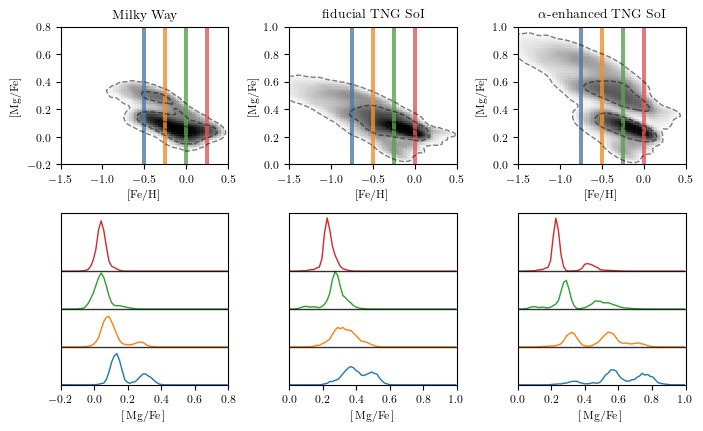

In [17]:
vmin = 0.08
vmax = 15

levels    = [0.1, 1.5, 10]
levels_MW = [0.1, 1.5, 10]

make_plot(MWdat, simdat, simdat_slope, vmin=vmin, vmax=vmax, save=True, levels=levels, levels_MW=levels_MW)

# alpha tform plot

In [29]:
np.sum(np.logical_not(np.isnan(MWdat['ages'])))

2525

In [82]:
def plot_alpha_panel(fig, ax0, ax1, dat, vmin=None, vmax=None, 
                     levels=[0.1, 1.5, 10], age_err=0.15, MgFe_err=0.01, add_obscut=None,
                    logNCFe_cut=None):
    
    logFeH_lim    = dat['logFeH_lim']
    logMgFe_lim   = dat['logMgFe_lim']
    logFeH0_list  = dat['logFeH0_list']
    N_FeH         = dat['N_FeH']
    N_MgFe        = dat['N_MgFe']
    FeH_centers   = dat['FeH_centers']
    MgFe_centers  = dat['MgFe_centers']
    logFeH        = dat['logFeH']
    logMgFe       = dat['logMgFe']
    keys          = dat['keys']
    H             = dat['H']
    is_obs        = dat['is_obs']
    
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0])/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    
    if is_obs:
        age = dat['ages']
        tlim = [0, meta['time'][99]]
    else:
        tform = dat['tform']
        age   = meta['time'][99] - tform
        tbins = dat['tbins']
        tlim = [tbins[0], tbins[-1]]
        in_SN = dat['is_star_in_SN']
    
    cmaps = ['Blues', 'Oranges', 'Greens', 'Reds']
    cs    = [tb_c[0], tb_c[1], tb_c[4], tb_c[2]]
    
    doffset = -0.5
    
    # ------- upper panel -------- #
    vmin = 7500
    vmax = 1750000
    
    # unmodified loop, with no adjustments to input tform or logMgFe
    if is_obs:
        ax = ax1
        offset = 0
        
        has_age = np.logical_not(np.isnan(age))
        
        if add_obscut is not None:
            has_age = np.logical_and(has_age, MWdat['age_err']/MWdat['ages'] < add_obscut)
            
        if logNCFe_cut is not None:
            has_age = np.logical_and(has_age, MWdat['logNCFe'] < logNCFe_cut)
        
        for c, cmap, key, logFeH0 in zip(cs, cmaps, keys, logFeH0_list):
            plot_key = np.logical_and(key, has_age)
            
            ax.scatter(age[plot_key], logMgFe[plot_key]+offset, c=c, s=0.5, alpha=0.5)
            
            offset += doffset
        
        ax.set(xlim=tlim, ylim=(logMgFe_lim[0]+doffset*3, logMgFe_lim[1] + dMgFe))
        ax.set_yticks([-1.7, -1.2, -0.7, -0.2, 0.3, 0.8])
        ax.set_ylabel(r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
        ax.set_xlabel(r'$\textrm{age}\,[\,\textrm{Gyr}\,]$')
        
        return
    
    
    ax = ax0
    offset = 0
    ybins = np.arange(logMgFe_lim[0]+doffset*3, logMgFe_lim[1] + dMgFe, dMgFe)
        
    for c, cmap, key, logFeH0 in zip(cs, cmaps, keys, logFeH0_list):
        H, _, _, _ = binned_statistic_2d(age[key], logMgFe[key]+offset, 
                                         np.ones(np.sum(key))/dFeH/dMgFe,
                                         statistic='sum', bins=[tbins, ybins])
    
        im = ax.imshow(H.T, origin='lower', extent=[tlim[0],  tlim[1], ybins[0], ybins[-1]],
                       cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='none')
    
        offset += doffset
    
    ax.set_ylabel(r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
    ax.set_xlabel(r'$\textrm{age}\,[\,\textrm{Gyr}\,]$')
        
    # we need to do the err plot
    age_werr = np.random.normal(age, age_err*age)
    logMgFe_werr = np.random.normal(logMgFe, MgFe_err)
    ax = ax1
    offset = 0
    
    for c, cmap, key, logFeH0 in zip(cs, cmaps, keys, logFeH0_list):
        # keys already include in SN cut
        H, _, _, _ = binned_statistic_2d(age_werr[key], logMgFe_werr[key]+offset, 
                                         np.ones(np.sum(key))/dFeH/dMgFe,
                                         statistic='sum', bins=[tbins, ybins])
    
        im = ax.imshow(H.T, origin='lower', extent=[tlim[0],  tlim[1], ybins[0], ybins[-1]],
                       cmap=cmap, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='none')
    
        offset += doffset
    
    ax.set_ylabel(r'$[\textrm{Mg}/\textrm{Fe}]+\textrm{offset}$')
    ax.set_xlabel(r'$\textrm{age}\,[\,\textrm{Gyr}\,]$')

def make_alpha_plot(MWdat, simdat, simdat_slope, save=False, show=True, vmin=None, vmax=None,
              levels=[0.01, 1, 10], levels_MW=[0.01, 1, 10], add_obscut=None,
                   age_err=0.15, MgFe_err=0.01, logNCFe_cut=None):
    
    fig, axs = plt.subplots(2, 3, figsize=(textwidth, 1.2*columnwidth))
    
    plot_alpha_panel(fig, axs[0][0], axs[1][0], MWdat, vmin=vmin, vmax=vmax, levels=levels_MW, add_obscut=add_obscut)
    axs[0][0].set_axis_off()
    axs[1][0].set_title(r'$\textrm{Milky Way}$')
               
    # placeholder
    # plot_alpha_panel(fig, axs[0][0], axs[1][0], simdat, vmin=vmin, vmax=vmax, levels=levels)
    
    plot_alpha_panel(fig, axs[0][1], axs[1][1], simdat, vmin=vmin, vmax=vmax, levels=levels, 
                     age_err=age_err, MgFe_err=MgFe_err, logNCFe_cut=logNCFe_cut)
    axs[0][1].set_title(r'$\textrm{fiducial TNG SOI}$')
    axs[1][1].set_title(r'$\textrm{with obs errors}$')
    
    plot_alpha_panel(fig, axs[0][2], axs[1][2], simdat_slope, vmin=vmin, vmax=vmax, levels=levels,
                    age_err=age_err, MgFe_err=MgFe_err)
    axs[0][2].set_title(r'$\alpha\textrm{-enhanced TNG SOI}$')
    axs[1][2].set_title(r'$\textrm{with obs errors}$')
    
    axs[0][1].axvline(10.6, c='k', ls='dashed', lw=1)
    axs[0][2].axvline(10.6, c='k', ls='dashed', lw=1)
    
    age15 = get_time(0, redshift=True) - get_time(1.5, redshift=True)
    print(age15)
    # axs[0][1].axvline(age15, c='k', ls='dashed', alpha=0.5, lw=1)
    # axs[0][2].axvline(age15, c='k', ls='dashed', alpha=0.5, lw=1)
    
    for x in axs.ravel():
        x.set_aspect('auto')
    
    fig.tight_layout()
    
    if save:
        fig.savefig(str(subID)+'_alpha.pdf')
        
    if not show:
        plt.close()

9.52086608577161


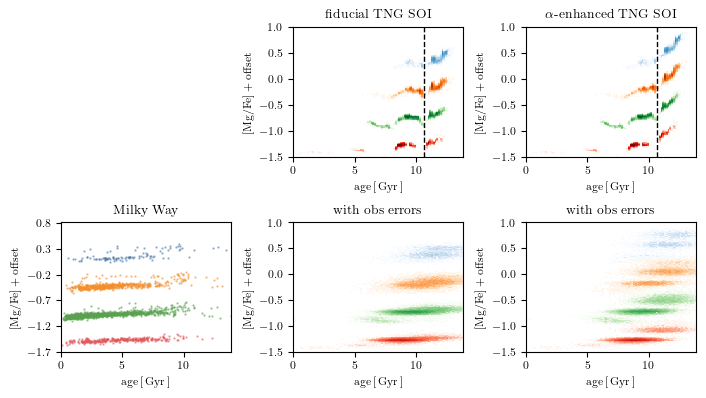

In [89]:
make_alpha_plot(MWdat, simdat, simdat_slope, save=True, add_obscut=0.25, age_err=0.125)

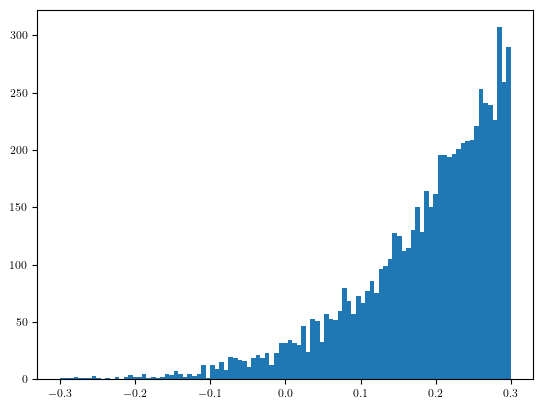

In [71]:
# plt.hist(MWdat['age_err']/MWdat['ages'], bins=np.linspace(0, 0.2, 100));
plt.hist(MWdat['logNCFe'], bins=np.linspace(-0.3, 0.3, 100));

# plot SFH

In [117]:
def mdot_eddington(bh_mass):
    GRAVITY = 6.6738e-8
    CLIGHT = 2.99792458e10
    PROTONMASS = 1.67262178e-24
    THOMPSON = 6.65245873e-25
    UnitTime_in_s = meta['header'][99].UnitLength_in_cm / meta['header'][99].UnitVelocity_in_cm_per_s
    
    BlackHoleRadiativeEfficiency = 0.2
    
    ans = 4*np.pi * GRAVITY * CLIGHT * PROTONMASS / (BlackHoleRadiativeEfficiency * CLIGHT * CLIGHT * THOMPSON)
    ans *= UnitTime_in_s / meta['header'][99].HubbleParam
    ans *= np.copy(bh_mass)
    
    return ans

In [122]:
def plot_SFH_panel(fig, ax, axz, subID, snapnum, Nbins=128):
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_InitialMass']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    # sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['GFM_InitialMass']
    
    # convert mass to 1e9Msun
    mass *= 10/meta['header'][snapnum].HubbleParam
    
    tbins = np.linspace(0, meta['time'][snapnum], Nbins+1)
    dt = tbins[1] - tbins[0]
    sfh, edges = np.histogram(tform, bins=tbins, weights=mass/dt)
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    time = meta['time'][MPB['SnapNum']]
    sfh = MPB['SubhaloSFR']
    ax.plot(time, sfh, c='k')
    
    
    # ax.plot(tcenter, sfh, c='k')
    ax.set(xlim=(0, meta['time'][99]))
    ax.set(ylim=(0, 70))
    # ax.set_yscale('log')
    
    ttran = meta['time'][99] - 10.6
    ax.axvline(ttran, c='k', ls='dashed', lw=1)
    
    # ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax.set_xticks(np.arange(0, 14, 1), minor=True)
    
    # now zoom
    dT = 3
    axz.plot(time, sfh, c='k')
    axz.set_ylim(ax.get_ylim())
    axz.set_yticks([])
    axz.axvline(ttran, c='k', ls='dashed', lw=1)
    
    axz.set(xlim=(2, 5))
    axz.set_xticks([2, 3, 4, 5])
    axz.set_xticks(np.arange(2, 5+0.25, 0.25), minor=True)
    
    return fig, ax, axz

def plot_AGN_panel(fig, ax, axz, subID, snapnum):
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    
    time = meta['time'][MPB['SnapNum']]
    Mdot = MPB['SubhaloBHMdot']
    MBH  = MPB['SubhaloBHMass']
    Mdot_edd = mdot_eddington(MBH)
    
    edd_fac = np.divide(Mdot, Mdot_edd, where=MBH>0)
    
    ax.plot(time, edd_fac, c='k')
    ax.set(xlim=(0, meta['time'][99]))
    # ax.set(ylim=(0.03, 50))
    # ax.set_yscale('log')
    
    ttran = meta['time'][99] - 10.6
    ax.axvline(ttran, c='k', ls='dashed', lw=1)
    
    # ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    # ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax.set(ylabel=r'$\dot{M}_{\textrm{BH}}/\dot{M}_{\textrm{Edd}}$')
    ax.set(ylim=(0, 0.5))
    ax.set_xticks(np.arange(0, 14, 1), minor=True)
    
    
    # now zoom
    dT = 3
    axz.plot(time, edd_fac, c='k')
    
    # axz.set(xlim=(ttran-dT/2., ttran+dT/2.))
    axz.set_ylim(ax.get_ylim())
    axz.set_yticks([])
    axz.axvline(ttran, c='k', ls='dashed', lw=1)
    
    axz.set(xlim=(2, 5))
    axz.set_xticks([2, 3, 4, 5])
    axz.set_xticks(np.arange(2, 5+0.25, 0.25), minor=True)
    
    return fig, ax, axz

def plot_M200_panel(fig, ax, axz, subID, snapnum):
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    
    time = meta['time'][MPB['SnapNum']]
    M200 = MPB['Group_M_Mean200']
    
    #convert to Msun
    M200 *= 1e10/meta['header'][99].HubbleParam
    
    ax.plot(time, M200/1e12, c='k')
    ax.set()
    # ax.set(ylim=(0.03, 50))
    # ax.set_yscale('log')
    
    ttran = meta['time'][99] - 10.6
    ax.axvline(ttran, c='k', ls='dashed', lw=1)
    print(meta['time'][99] - 10.6)
    
    ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    # ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax.set(ylabel=r'$M_{200}\,[\,10^{12}M_{\odot}\,]$')
    # ax.set(ylim=(1e9, 1e13))
    ax.set(ylim=(0, 5.5))
    
    ax.set_xticks(np.arange(0, 14, 1), minor=True)
    ax.set_xlim((0, meta['time'][99]))
    
    # now zoom
    dT = 3
    axz.plot(time, M200/1e12, c='k')
    
    axz.set_ylim(ax.get_ylim())
    axz.set_yticks([])
    
    axz.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    axz.axvline(ttran, c='k', ls='dashed', lw=1)
    
    axz.set(xlim=(2, 5))
    axz.set_xticks([2, 3, 4, 5])
    axz.set_xticks(np.arange(2, 5+0.25, 0.25), minor=True)
    
    return fig, ax, axz

def make_SFH_AGN_M200_plot(subID, snapnum):
    fig, axs = plt.subplots(3, 2, figsize=(columnwidth, 1.2*columnwidth), width_ratios=[1.5,1])
    
    fig, axs[0][0], axs[0][1] = plot_SFH_panel(fig, axs[0][0], axs[0][1], subID, snapnum)
    
    fig, axs[1][0], axs[1][1] = plot_AGN_panel(fig, axs[1][0], axs[1][1], subID, snapnum)
    
    fig, axs[2][0], axs[2][1] = plot_M200_panel(fig, axs[2][0], axs[2][1], subID, snapnum)
    
    fig.tight_layout()
    
    fig.savefig(str(subID)+'_SFH_AGN_M200.pdf')
    
    plt.show()
    
    plt.close()

3.2027199854852384


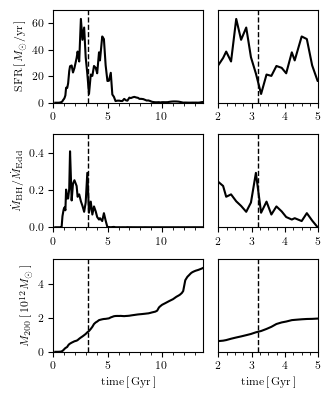

In [123]:
make_SFH_AGN_M200_plot(subID, snapnum)
plt.close()

# observational errors

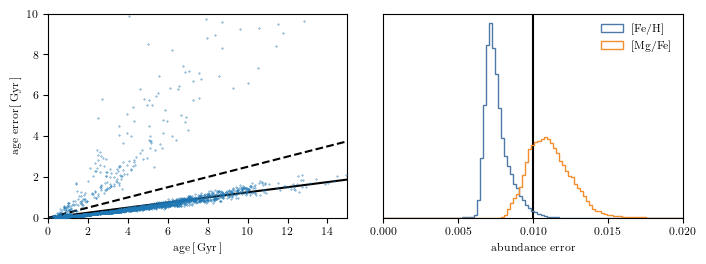

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(textwidth, 0.8*columnwidth))

# age errors
ax = axs[0]

x = np.linspace(0, 20, 100)
ax.plot(x, 0.125*x, c='k')
ax.plot(x, 0.25*x, c='k', ls='dashed')

key = np.logical_not(np.isnan(MWdat['ages']))
ax.scatter(MWdat['ages'][key], MWdat['age_err'][key], s=0.1, zorder=3)


ax.set(xlim=(0, 15), ylim=(0, 10))

ax.set_xlabel(r'$\textrm{age}\,[\,\textrm{Gyr}\,]$')
ax.set_ylabel(r'$\textrm{age error}\,[\,\textrm{Gyr}\,]$')

# metallicity errors
ax = axs[1]
bins = np.linspace(0, 0.02, 100)
ax.axvline(0.01, c='k')

ax.hist(MWdat['logFeH_err'], bins=bins, histtype='step', color=tb_c[0], density=True, label=r'$[\textrm{Fe}/\textrm{H}]$')
ax.hist(MWdat['logMgFe_err'], bins=bins, histtype='step', color=tb_c[1], density=True, label=r'$[\textrm{Mg}/\textrm{Fe}]$')
ax.legend(frameon=False)

ax.set(xlim=(bins[0], bins[-1]))
ax.set_xlabel(r'$\textrm{abundance error}$')

ax.set_xticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_yticks([])

fig.tight_layout()

fig.savefig('obs_error.pdf')

In [29]:
for k in MWdat.keys():
    print(k)

ages
age_err
logFeH
logMgFe
logFeH_err
logMgFe_err
N_FeH
N_MgFe
logFeH_lim
logMgFe_lim
FeH_centers
MgFe_centers
H
logFeH0_list
keys
is_obs


In [198]:
morph = h5.File(basepath+'/data/morphs_kinematic_bars.hdf5', mode='r')
print(morph['Snapshot_30']['QualityFlags'][:,3])
morph.close()

[0.687225 0.679036 0.948747]


In [202]:
def get_A2max(MPB, return_quality=False):
    morph = h5.File(basepath+'/data/morphs_kinematic_bars.hdf5', mode='r')
    A2max = np.zeros_like(MPB['SnapNum'], dtype=float)
    quality = np.zeros((len(MPB['SnapNum']), 3))
    for i,snapnum in enumerate(MPB['SnapNum']):
        snapstr = 'Snapshot_'+str(snapnum)
        
        if snapstr not in morph.keys():
            A2max[i] = 0.0
            continue
        
        k = np.where(morph[snapstr]['SubhaloID'] == MPB['SubfindID'][i])[0]
        assert len(k) <= 1
        if len(k) == 0:
            A2max[i] = 0.0
            continue
        k = k[0]
        
        # print(k)
        # print(morph[snapstr]['Barred'][k], morph[snapstr]['BarStrength'][0,k])
        
        A2max[i] = morph[snapstr]['BarStrength'][0][k]
        quality[i] = morph[snapstr]['QualityFlags'][:,k]
    
    morph.close()
    
    if return_quality:
        return A2max, quality
    else:
        return A2max

In [182]:
def plot_zoom_SFH(fig, ax, ax2, subID, snapnum, Nbins=1024, xlim=(None, None)):
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_InitialMass']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    # sub = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['GFM_InitialMass']
    
    # convert mass to 1e9Msun
    mass *= 10/meta['header'][snapnum].HubbleParam
    
    tbins = np.linspace(0, meta['time'][snapnum], Nbins+1)
    dt = tbins[1] - tbins[0]
    sfh, edges = np.histogram(tform, bins=tbins, weights=mass/dt)
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    # ax.plot(tcenter, sfh, c=tb_c[0])
    
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    time = meta['time'][MPB['SnapNum']]
    sfh = MPB['SubhaloSFRinRad']
    lns = ax.plot(time, sfh, c=tb_c[0], label=r'$\textrm{SFR}$')
    
    ax.set(xlim=xlim)
    ax.set(ylim=(0, 100))
    # ax.set_yscale('log')
    
    ax.axvline(meta['time'][99] - 10.6, c='k', ls='dashed', lw=1)
    
    # for i in range(100):
        # if meta['time'][i] > xlim[0] and meta['time'][i] < xlim[1]:
            # c = 'r' if i==30 else 'k'
            # ax.axvline(meta['time'][i], c=c)
    
    # ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    
    return fig, ax, ax2, lns

def plot_zoom_AGN(fig, ax, ax2, subID, snapnum, xlim=(None, None)):
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    
    time = meta['time'][MPB['SnapNum']]
    Mdot = MPB['SubhaloBHMdot']
    MBH  = MPB['SubhaloBHMass']
    Mdot_edd = mdot_eddington(MBH)
    
    edd_fac = np.divide(Mdot, Mdot_edd, where=MBH>0)
    
    lns = ax2.plot(time, edd_fac, c=tb_c[1], label=r'$\dot{M}/\dot{M}_{\textrm{Edd}}$')
    # ax.set(ylim=(0.03, 50))
    # ax.set_yscale('log')
    
    # ax.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
    # ax.set(ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax2.set(ylabel=r'$\dot{M}/\dot{M}_{\textrm{Edd}}\textrm{ or }A_{2,\textrm{max}}/2$')
    ax2.set(ylim=(0, 0.5))
    
    return fig, ax, ax2, lns

def plot_zoom_A2max(fig, ax, ax2, subID, snapnum, xlim=(None, None)):
    MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)
    A2max = get_A2max(MPB)
    
    time = meta['time'][MPB['SnapNum']]
    key = A2max >= 0
    lns = ax2.plot(time[key], A2max[key]/2, c=tb_c[2], label=r'$A_{2,\textrm{max}}/2$')
    
    return fig, ax, ax2, lns

def make_SFH_AGN_M200_plot(subID, snapnum):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth), sharex=True)
    
    ax2 = ax.twinx()
    
    xlim=(1.5, 4.5)
    
    fig, ax, ax2, lns0 = plot_zoom_SFH(fig, ax, ax2, subID, snapnum, xlim=xlim)
    
    fig, ax, ax2, lns1 = plot_zoom_AGN(fig, ax, ax2, subID, snapnum, xlim=xlim)
    
    fig, ax, ax2, lns2 = plot_zoom_A2max(fig, ax, ax2, subID, snapnum, xlim=xlim)
    
    lns = lns0+lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, frameon=False)
    ax.set_xlabel(r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')
        
    fig.tight_layout()
    
    fig.savefig(str(subID)+'_SFH_AGN_M200_zoomed.pdf')
    
    plt.show()
    
    plt.close()

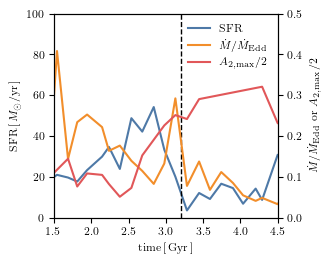

In [183]:
make_SFH_AGN_M200_plot(subID, snapnum)

In [118]:
MPB = il.sublink.loadTree(TNGbase, snapnum, subID, onlyMPB=True)

MBH  = MPB['SubhaloBHMass']
Mdot = MPB['SubhaloBHMdot']
Mdot_edd = mdot_eddington(MBH)
    
edd_fac = np.divide(Mdot, Mdot_edd, where=MBH>0)

sfh = MPB['SubhaloSFR']
time = meta['time'][MPB['SnapNum']]
redshift = meta['redshift'][MPB['SnapNum']]
mgas = MPB['SubhaloMassInRadType'][:,0]
mgas_inmsun = 1e10*mgas/meta['header'][0].HubbleParam

for i in [76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58]:
    print(i, round(time[i], 3), round(redshift[i], 3), MPB['SnapNum'][i], sfh[i], edd_fac[i], A2max[i])

NameError: name 'get_A2max' is not defined

In [235]:
for i in [76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63]:
    print(i, round(time[i], 3), round(redshift[i], 3), MPB['SnapNum'][i], mgas_inmsun[i]/sfh[i]/1e6)

76 1.812 3.491 23 662.628672
75 1.944 3.283 24 556.3392
74 2.145 3.008 25 451.531968
73 2.238 2.896 26 369.273696
72 2.384 2.733 27 407.486624
71 2.539 2.577 28 271.6008
70 2.685 2.444 29 280.341024
69 2.839 2.316 30 203.604896
68 2.98 2.208 31 165.963376
67 3.129 2.103 32 102.038864
66 3.284 2.002 33 318.517984
65 3.447 1.904 34 190.735488
64 3.593 1.823 35 322.707872
63 3.744 1.744 36 222.205472


In [236]:
deptime = 0.0
N = 0
for i in [68, 67, 66, 65, 64]:
    deptime += mgas_inmsun[i]/sfh[i]/1e6
    N += 1
print(deptime/N)

219.9927168


# plot SFH using stellar ages

In [160]:
for k in MPB.keys():
    if 'Subhalo' in k:
        print(k)

FirstSubhaloInFOFGroupID
NextSubhaloInFOFGroupID
SubhaloBHMass
SubhaloBHMdot
SubhaloCM
SubhaloGasMetalFractions
SubhaloGasMetalFractionsHalfRad
SubhaloGasMetalFractionsMaxRad
SubhaloGasMetalFractionsSfr
SubhaloGasMetalFractionsSfrWeighted
SubhaloGasMetallicity
SubhaloGasMetallicityHalfRad
SubhaloGasMetallicityMaxRad
SubhaloGasMetallicitySfr
SubhaloGasMetallicitySfrWeighted
SubhaloGrNr
SubhaloHalfmassRad
SubhaloHalfmassRadType
SubhaloID
SubhaloIDMostbound
SubhaloIDRaw
SubhaloLen
SubhaloLenType
SubhaloMass
SubhaloMassInHalfRad
SubhaloMassInHalfRadType
SubhaloMassInMaxRad
SubhaloMassInMaxRadType
SubhaloMassInRad
SubhaloMassInRadType
SubhaloMassType
SubhaloParent
SubhaloPos
SubhaloSFR
SubhaloSFRinHalfRad
SubhaloSFRinMaxRad
SubhaloSFRinRad
SubhaloSpin
SubhaloStarMetalFractions
SubhaloStarMetalFractionsHalfRad
SubhaloStarMetalFractionsMaxRad
SubhaloStarMetallicity
SubhaloStarMetallicityHalfRad
SubhaloStarMetallicityMaxRad
SubhaloStellarPhotometrics
SubhaloStellarPhotometricsMassInRad
Subhalo

In [151]:
# get trajectory of MPB
from scipy.interpolate import CubicSpline
pos = MPB['SubhaloPos']
time = meta['time'][MPB['SnapNum']]
rhalf = MPB['SubhaloHalfmassRadType'][:,4]

time = np.flip(time)
pos = np.flip(pos, axis=0)

posint = CubicSpline(time, pos)
rhalfint = CubicSpline(time, rhalf)

# load in subhalo
sub = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=['BirthPos', 'GFM_StellarFormationTime'])

tform = get_time(sub['GFM_StellarFormationTime'])
rhalf_attform = rhalfint(tform)
pos_attform = posint(tform)
birthpos = sub['BirthPos']

rdiff = np.linalg.norm(pos_attform - birthpos, axis=1)
in_situ = rdiff < 20

/tmp/ipykernel_3820749/4002541470.py:16: RuntimeWarning: overflow encountered in divide
  ans /= HUBBLE * HubbleParam


In [152]:

# key = simdat['is_star_in_SN']
tform = simdat['tform'][in_situ]
minit = simdat['minit'][in_situ]
minit_inmsun = 1e10 * minit / meta['header'][99].HubbleParam

dt = 0.05
dt_inyr = dt * 1e9
tbins = np.arange(0, meta['time'][99]+dt, dt)

sfh, bin_edges = np.histogram(tform, bins=tbins, weights=minit_inmsun/dt_inyr)

t0 = 0.5 * (bin_edges[:-1] + bin_edges[1:])

Text(0, 0.5, 'SFR [msun/yr]')

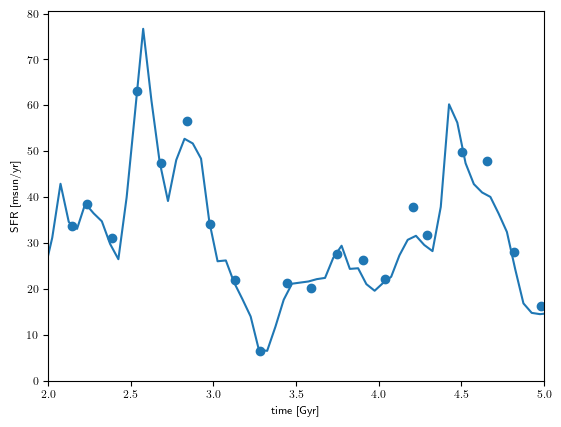

In [161]:
plt.plot(t0, sfh)

plt.scatter(meta['time'][MPB['SnapNum']], MPB['SubhaloSFR'])

# ax = plt.gca()
# axt = ax.twinx()
# axt.scatter(meta['time'][MPB['SnapNum']], MPB['SubhaloHalfmassRadType'][:,4], c='k')

# plt.xlim(0, meta['time'][99])
plt.xlim(2, 5)
plt.ylim(0, None)

plt.xlabel('time [Gyr]')
plt.ylabel('SFR [msun/yr]')

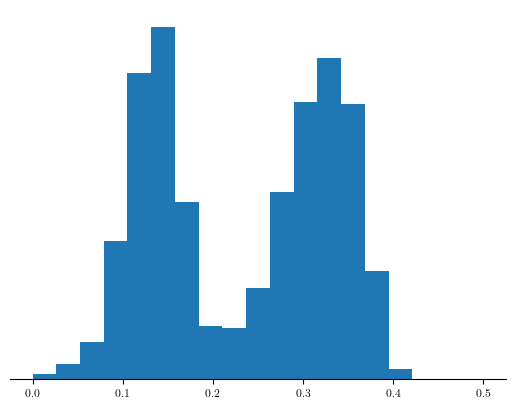

In [136]:
key = np.logical_and(MWdat['logFeH'] > -1, MWdat['logFeH'] < -0.5)
plt.hist(MWdat['logMgFe'][key], bins=np.linspace(0, 0.5, 20), density=True)

# Remove left, top, and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y-ticks
plt.yticks([])
plt.savefig('harv_horiz.pdf')
plt.show()
